The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.5
!pip install -U mxnet-cu101==1.7.0


# Sequence Models
:label:`sec_sequence`

Imagine that you are watching movies on Netflix. As a good Netflix user, you decide to rate each of the movies religiously. After all, a good movie is a good movie, and you want to watch more of them, right? As it turns out, things are not quite so simple. People's opinions on movies can change quite significantly over time. In fact, psychologists even have names for some of the effects:

* There is *anchoring*, based on someone else's opinion. For instance, after the Oscar awards, ratings for the corresponding movie go up, even though it is still the same movie. This effect persists for a few months until the award is forgotten. It has been shown that the effect lifts rating by over half a point
:cite:`Wu.Ahmed.Beutel.ea.2017`.
* There is the *hedonic adaptation*, where humans quickly adapt to accept an improved or a worsened situation as the new normal. For instance, after watching many good movies, the expectations that the next movie is equally good or better are high. Hence, even an average movie might be considered as bad after many great ones are watched.
* There is *seasonality*. Very few viewers like to watch a Santa Claus movie in August.
* In some cases, movies become unpopular due to the misbehaviors of directors or actors in the production.
* Some movies become cult movies, because they were almost comically bad. *Plan 9 from Outer Space* and *Troll 2* achieved a high degree of notoriety for this reason.

In short, movie ratings are anything but stationary. Thus, using temporal dynamics
led to more accurate movie recommendations :cite:`Koren.2009`.
Of course, sequence data are not just about movie ratings. The following gives more illustrations.

* Many users have highly particular behavior when it comes to the time when they open apps. For instance, social media apps are much more popular after school with students. Stock market trading apps are more commonly used when the markets are open.
* It is much harder to predict tomorrow's stock prices than to fill in the blanks for a stock price we missed yesterday, even though both are just a matter of estimating one number. After all, foresight is so much harder than hindsight. In statistics, the former (predicting beyond the known observations) is called *extrapolation* whereas the latter (estimating between the existing observations) is called *interpolation*.
* Music, speech, text, and videos are all sequential in nature. If we were to permute them they would make little sense. The headline *dog bites man* is much less surprising than *man bites dog*, even though the words are identical.
* Earthquakes are strongly correlated, i.e., after a massive earthquake there are very likely several smaller aftershocks, much more so than without the strong quake. In fact, earthquakes are spatiotemporally correlated, i.e., the aftershocks typically occur within a short time span and in close proximity.
* Humans interact with each other in a sequential nature, as can be seen in Twitter fights, dance patterns, and debates.

## Statistical Tools

We need statistical tools and new deep neural network architectures to deal with sequence data. To keep things simple, we use the stock price (FTSE 100 index) illustrated in :numref:`fig_ftse100` as an example.

![FTSE 100 index over about 30 years.](../img/ftse100.png)
:width:`400px`
:label:`fig_ftse100`


Let us denote the prices by $x_t$, i.e., at *time step* $t \in \mathbb{Z}^+$ we observe price $x_t$.
Note that for sequences in this text,
$t$ will typically be discrete and vary over integers or its subset.
Suppose that
a trader who wants to do well in the stock market on day $t$ predicts $x_t$ via

$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1).$$

### Autoregressive Models

In order to achieve this, our trader could use a regression model such as the one that we trained in :numref:`sec_linear_concise`.
There is just one major problem: the number of inputs, $x_{t-1}, \ldots, x_1$ varies, depending on $t$.
That is to say, the number increases with the amount of data that we encounter, and we will need an approximation to make this computationally tractable.
Much of what follows in this chapter will revolve around how to estimate $P(x_t \mid x_{t-1}, \ldots, x_1)$ efficiently. In a nutshell it boils down to two strategies as follows.

First, assume that the potentially rather long sequence $x_{t-1}, \ldots, x_1$ is not really necessary.
In this case we might content ourselves with some timespan of length $\tau$ and only use $x_{t-1}, \ldots, x_{t-\tau}$ observations. The immediate benefit is that now the number of arguments is always the same, at least for $t > \tau$. This allows us to train a deep network as indicated above. Such models will be called *autoregressive models*, as they quite literally perform regression on themselves.

The second strategy, shown in :numref:`fig_sequence-model`, is to keep some summary $h_t$ of the past observations, and at the same time update $h_t$ in addition to the prediction $\hat{x}_t$.
This leads to models that estimate $x_t$ with $\hat{x}_t = P(x_t \mid h_{t})$ and moreover updates of the form  $h_t = g(h_{t-1}, x_{t-1})$. Since $h_t$ is never observed, these models are also called *latent autoregressive models*.

![A latent autoregressive model.](../img/sequence-model.svg)
:label:`fig_sequence-model`

Both cases raise the obvious question of how to generate training data. One typically uses historical observations to predict the next observation given the ones up to right now. Obviously we do not expect time to stand still. However, a common assumption is that while the specific values of $x_t$ might change, at least the dynamics of the sequence itself will not. This is reasonable, since novel dynamics are just that, novel and thus not predictable using data that we have so far. Statisticians call dynamics that do not change *stationary*.
Regardless of what we do, we will thus get an estimate of the entire sequence via

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}, \ldots, x_1).$$

Note that the above considerations still hold if we deal with discrete objects, such as words, rather than continuous numbers. The only difference is that in such a situation we need to use a classifier rather than a regression model to estimate $P(x_t \mid  x_{t-1}, \ldots, x_1)$.

### Markov Models

Recall the approximation that in an autoregressive model we use only $x_{t-1}, \ldots, x_{t-\tau}$ instead of $x_{t-1}, \ldots, x_1$ to estimate $x_t$. Whenever this approximation is accurate we say that the sequence satisfies a *Markov condition*. In particular, if $\tau = 1$, we have a *first-order Markov model* and $P(x)$ is given by

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ where } P(x_1 \mid x_0) = P(x_1).$$

Such models are particularly nice whenever $x_t$ assumes only a discrete value, since in this case dynamic programming can be used to compute values along the chain exactly. For instance, we can compute $P(x_{t+1} \mid x_{t-1})$ efficiently:

$$\begin{aligned}
P(x_{t+1} \mid x_{t-1})
&= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})}\\
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})}\\
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{aligned}
$$

by using the fact that we only need to take into account a very short history of past observations: $P(x_{t+1} \mid x_t, x_{t-1}) = P(x_{t+1} \mid x_t)$.
Going into details of dynamic programming is beyond the scope of this section. Control and reinforcement learning algorithms use such tools extensively.

### Causality

In principle, there is nothing wrong with unfolding $P(x_1, \ldots, x_T)$ in reverse order. After all, by conditioning we can always write it via

$$P(x_1, \ldots, x_T) = \prod_{t=T}^1 P(x_t \mid x_{t+1}, \ldots, x_T).$$

In fact, if we have a Markov model, we can obtain a reverse conditional probability distribution, too. In many cases, however, there exists a natural direction for the data, namely going forward in time. It is clear that future events cannot influence the past. Hence, if we change $x_t$, we may be able to influence what happens for $x_{t+1}$ going forward but not the converse. That is, if we change $x_t$, the distribution over past events will not change. Consequently, it ought to be easier to explain $P(x_{t+1} \mid x_t)$ rather than $P(x_t \mid x_{t+1})$. For instance, it has been shown that in some cases we can find $x_{t+1} = f(x_t) + \epsilon$ for some additive noise $\epsilon$, whereas the converse is not true :cite:`Hoyer.Janzing.Mooij.ea.2009`. This is great news, since it is typically the forward direction that we are interested in estimating.
The book by Peters et al. has
explained more on this topic :cite:`Peters.Janzing.Scholkopf.2017`.
We are barely scratching the surface of it.


## Training

After reviewing so many statistical tools,
let us try this out in practice.
We begin by generating some data.
To keep things simple we (**generate our sequence data by using a sine function with some additive noise for time steps $1, 2, \ldots, 1000$.**)


In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

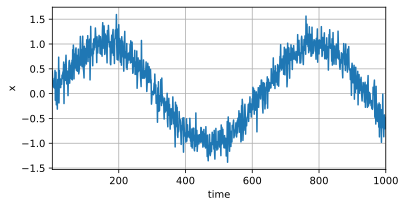

In [2]:
T = 1000  # Generate a total of 1000 points
time = np.arange(1, T + 1, dtype=np.float32)
x = np.sin(0.01 * time) + np.random.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

Next, we need to turn such a sequence into features and labels that our model can train on.
Based on the embedding dimension $\tau$ we [**map the data into pairs $y_t = x_t$ and $\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$.**]
The astute reader might have noticed that this gives us $\tau$ fewer data examples, since we do not have sufficient history for the first $\tau$ of them.
A simple fix, in particular if the sequence is long,
is to discard those few terms.
Alternatively we could pad the sequence with zeros.
Here we only use the first 600 feature-label pairs for training.


In [3]:
tau = 4
features = np.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [4]:
batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

Here we [**keep the architecture fairly simple:
just an MLP**] with two fully-connected layers, ReLU activation, and squared loss.


In [5]:
# A simple MLP
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(10, activation='relu'),
            nn.Dense(1))
    net.initialize(init.Xavier())
    return net

# Square loss
loss = gluon.loss.L2Loss()

Now we are ready to [**train the model**]. The code below is essentially identical to the training loop in previous sections,
such as :numref:`sec_linear_concise`.
Thus, we will not delve into much detail.


In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    for epoch in range(epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

[01:01:31] src/base.cc:49: GPU context requested, but no GPUs found.


epoch 1, loss: 0.039573


epoch 2, loss: 0.030332


epoch 3, loss: 0.029445


epoch 4, loss: 0.027036


epoch 5, loss: 0.026754


## Prediction

Since the training loss is small, we would expect our model to work well. Let us see what this means in practice. The first thing to check is how well the model is able to [**predict what happens just in the next time step**],
namely the *one-step-ahead prediction*.


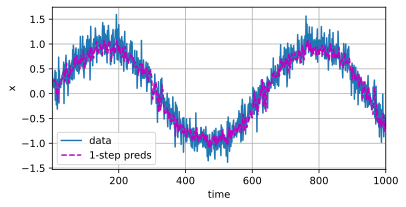

In [7]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.asnumpy(), onestep_preds.asnumpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

The one-step-ahead predictions look nice, just as we expected.
Even beyond 604 (`n_train + tau`) observations the predictions still look trustworthy.
However, there is just one little problem to this:
if we observe sequence data only until time step 604, we cannot hope to receive the inputs for all the future one-step-ahead predictions.
Instead, we need to work our way forward one step at a time:

$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

Generally, for an observed sequence up to $x_t$, its predicted output $\hat{x}_{t+k}$ at time step $t+k$ is called the $k$*-step-ahead prediction*. Since we have observed up to $x_{604}$, its $k$-step-ahead prediction is $\hat{x}_{604+k}$.
In other words, we will have to [**use our own predictions to make multistep-ahead predictions**].
Let us see how well this goes.


In [8]:
multistep_preds = np.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

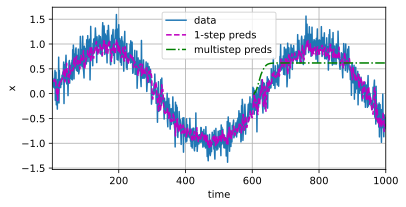

In [9]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.asnumpy(), onestep_preds.asnumpy(),
          multistep_preds[n_train + tau:].asnumpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

As the above example shows, this is a spectacular failure. The predictions decay to a constant pretty quickly after a few prediction steps.
Why did the algorithm work so poorly?
This is ultimately due to the fact that the errors build up.
Let us say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$.
Now the *input* for step 2 is perturbed by $\epsilon_1$, hence we suffer some error in the order of $\epsilon_2 = \bar\epsilon + c \epsilon_1$ for some constant $c$, and so on. The error can diverge rather rapidly from the true observations. This is a common phenomenon. For instance, weather forecasts for the next 24 hours tend to be pretty accurate but beyond that the accuracy declines rapidly. We will discuss methods for improving this throughout this chapter and beyond.

Let us [**take a closer look at the difficulties in $k$-step-ahead predictions**]
by computing predictions on the entire sequence for $k = 1, 4, 16, 64$.


In [10]:
max_steps = 64

In [11]:
features = np.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

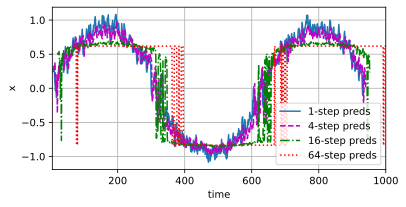

In [12]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].asnumpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

This clearly illustrates how the quality of the prediction changes as we try to predict further into the future.
While the 4-step-ahead predictions still look good, anything beyond that is almost useless.


## Summary

* There is quite a difference in difficulty between interpolation and extrapolation. Consequently, if you have a sequence, always respect the temporal order of the data when training, i.e., never train on future data.
* Sequence models require specialized statistical tools for estimation. Two popular choices are autoregressive models and latent-variable autoregressive models.
* For causal models (e.g., time going forward), estimating the forward direction is typically a lot easier than the reverse direction.
* For an observed sequence up to time step $t$, its predicted output at time step $t+k$ is the $k$*-step-ahead prediction*. As we predict further in time by increasing $k$, the errors accumulate and the quality of the prediction degrades, often dramatically.


## Exercises

1. Improve the model in the experiment of this section.
    1. Incorporate more than the past 4 observations? How many do you really need?
    1. How many past observations would you need if there was no noise? Hint: you can write $\sin$ and $\cos$ as a differential equation.
    1. Can you incorporate older observations while keeping the total number of features constant? Does this improve accuracy? Why?
    1. Change the neural network architecture and evaluate the performance.
1. An investor wants to find a good security to buy. He looks at past returns to decide which one is likely to do well. What could possibly go wrong with this strategy?
1. Does causality also apply to text? To which extent?
1. Give an example for when a latent autoregressive model might be needed to capture the dynamic of the data.


[Discussions](https://discuss.d2l.ai/t/113)
